# 利用 OpenCV 实现基于 PCA 算法的人脸识别

### 人脸识别简介

人脸识别是基于人的脸部特征信息进行身份识别的一种生物识别技术。其识别过程为：人脸图像采集及检测、人脸图像预处理、人脸图像特征提取、匹配与识别

### PCA算法
PCA(Principal Component Analysis)，即主成分分析⽅法，是⼀种使⽤最⼴泛的数据降维算法。PCA的主要思想是将n维特征映射到k维上，这k维
是全新的正交特征也被称原有n维特征的基础上重新构造出来的k维特征。PCA的⼯作就是从原始的空间中顺序地找⼀组相互正交的坐标轴，新的
坐标轴的选择与数据本⾝是密切相关的。其中，第⼀是原始数据中⽅差最⼤的⽅向，第⼆个新坐标轴选取是与第⼀个坐标轴正交的平⾯中使得⽅差
最⼤的，第三个轴是与第1,2个轴正交的平⾯中⽅差最⼤的。依次类推，可以得标轴。通过这种⽅式获得的新的坐标轴，我们发现，⼤部分⽅差都
包含在前⾯k个坐标轴中，后⾯的坐标轴所含的⽅差⼏乎为0。于是，我们可以忽略余下的坐标轴，只保留⼤部分⽅差的坐标轴。事实上，这相当
于只保留包含绝⼤部分⽅差的维度特征，⽽忽略包含⽅差⼏乎为0的特征维度，实现对数据特征的降维处理。

总结⼀下PCA的算法步骤： 设有m条n维数据。 1）将原始数据按列组成n⾏m列矩阵X 2）将X的每⼀⾏（代表⼀个属性字段）进⾏零均值化，即减去这⼀⾏的均值 3）求出协⽅差矩阵 4）求出协⽅差矩阵的特征值及对应的特征向量 5）将特征向量按对应特征值⼤⼩从上到下按⾏排列成矩阵，取前k⾏组成矩阵P 6）Y=PX即为降维到k维后的数据

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn import metrics 
from numpy import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import imageio
import warnings

#忽略一些版本不兼容等警告
warnings.filterwarnings("ignore")

## att_face人脸数据集

### 一、加载并处理图片

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 2

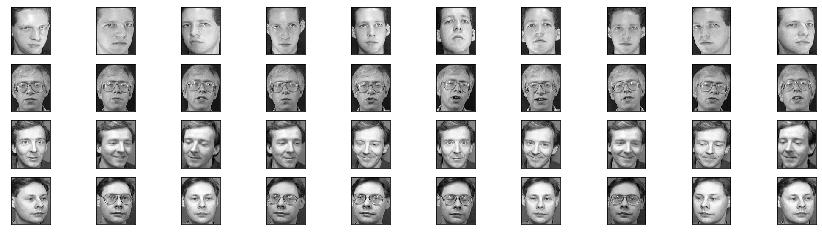

In [21]:
#读取所有训练图片
def read_images():
    faces = []
    dataSetDir = 'face_database/att_face'
    choose = random.permutation(10)+1 #随机排序1-10 (0-9）+1
    for i in range(40):  #有40个人
        people_num = i+1
        for j in range(10):  #每个人有10张脸不同的脸
            filename = dataSetDir+'/s'+str(people_num)+'/'+str(choose[j])+'.pgm'  #图片地址
            faces.append(filename)
    images,labels = [],[] 
    i = 0
    for face in faces: 
        image = cv2.imread(face,0)
        images.append(image)
        labels.append(int(i/10)+1)
        i = i+1
    return images,labels

#显示读取的人脸
def show_image(images,i):
    plt.figure(figsize=(15,4))
    for j in range(i*10) :
        plt.subplot(i,10,j+1)
        plt.imshow(images[j],'gray') #灰度
        plt.xticks([]),plt.yticks([])

def change(images):
    img_data = []
    for img in images:
        data = img.flatten()  #转换为一维数组
        img_data.append(data)
    return img_data

images,labels = read_images()
print(labels)  #显示标签
show_image(images,4)  #显示部分人脸图片
img_data = change(images)

### 二、使用sklean自带的PCA算法进行数据降维，并求出特征值和平均值

(400, 10304)
降维后的训练数据： (320, 50)
降维后的测试数据： (80, 50)
特征脸：


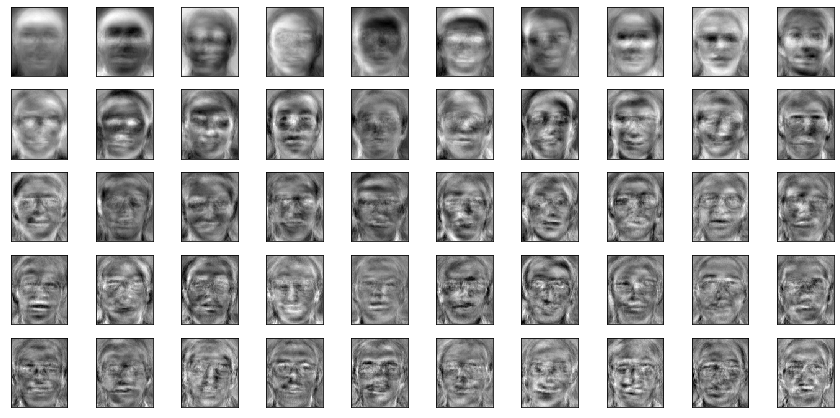

平均特征值： [84.796875 84.51875  84.940625 ... 77.375    76.0625   75.559375]
平均特征脸：


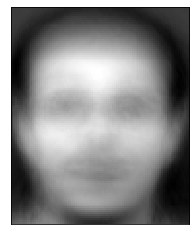

[0.18137947 0.12652797 0.06852244 0.05460447 0.05050816 0.03287011
 0.02531217 0.0238167  0.02010111 0.0179679  0.01500284 0.014453
 0.01157406 0.01098371 0.01008825 0.00943349 0.00918163 0.00897313
 0.00737121 0.00693847 0.00674234 0.0064073  0.00592536 0.0057586
 0.00526994 0.00519775 0.00501067 0.00482753 0.00463109 0.00440008
 0.00430489 0.00418469 0.00397218 0.00379112 0.00370024 0.00364482
 0.00357732 0.00345647 0.00332161 0.00319544 0.0030324  0.00296777
 0.00287179 0.00284051 0.00272961 0.00263901 0.00259363 0.00251398
 0.00248028 0.00245922]


In [22]:
#PCA算法是一种数据降维的方法，它可以对于数据进行维度降低，实现提高数据计算和训练的效率
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

data_img = np.array(img_data)
data_label = np.array(labels)
print(data_img.shape)  #原图形的尺寸

x_train,x_test,y_train,y_test = train_test_split(data_img,data_label, test_size=0.2)

pca = PCA(n_components=50)   #参数n_components表示保留的特征数，默认为1。如果设置成‘mle’,那么会自动确定保留的特征数
pca.fit(x_train,y_train)   #训练pca模型

# 将数据转换成降维后的数据
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print('降维后的训练数据：',x_train_pca.shape)   #降维后的尺寸
print('降维后的测试数据：',x_test_pca.shape)

character = pca.components_   #返回具有最大方差的成分
mean = pca.mean_  #平均特征值

print('特征脸：')
#画出特征脸
plt.figure(figsize=(15,15))
for j in range(pca.n_components_) :
    plt.subplot(10,10,j+1)
    plt.imshow(character[j,:].reshape(112,92),"gray") #灰度
    plt.xticks([]),plt.yticks([])
plt.show()

print('平均特征值：',mean)
#画出平均特征脸
print('平均特征脸：')
plt.figure(figsize=(4,4))
plt.imshow(mean.reshape(112,92),'gray')
plt.xticks([]),plt.yticks([])
plt.show()
    
    
#参数 explained_variance_ratio_：array, [n_components]返回 所保留的n个成分各自的方差百分比
#,这里可以理解为单个变量方差贡献率
print(pca.explained_variance_ratio_)


### 三、使用不同分类器进行对人脸识别 

### （1）SVM分类器

In [23]:
#使用svm分类器
svc = SVC()
svc.fit(x_train_pca,y_train)
y_pred = svc.predict(x_test_pca)

print('预测值：',y_pred)
print('实际值：',y_test)
print('准确率：',svc.score(x_test_pca,y_test))
print(metrics.confusion_matrix(y_test,y_pred))      #混淆矩阵

预测值： [12 38 38 35 40 24 11 23 27 30 15 21  5 12 17 33 17  7 35 37 13 18 32 30
 29  6  7  8 25 16  3 21  9  4  1 40 34 32 21 34  4  6 26 11 30  5 19 25
  6 20 36  3 28 22 30 19  7 13  8 40 12 37 18  9  6 26 11 13 39 28 20 14
  7 12 22 37 27 27 21 31]
实际值： [12 38 38 35 40 24 11 23 27 30 15 21  5 12 17 33 17  7 35 37 13 18 32 30
 29  6  7  8 25 16  3 21  9  4  1 40 34 32 21 34  4  6 26 11 30  5 19 25
  6 20 36  3 28 22 30 19  7 13  8 35 12 37 18  9  6 26 11 13 39 28 20 14
  7 12 22 37 27 27 21 31]
准确率： 0.9875
[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]


### （2）kNN算法

In [24]:
#使用kNN算法
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_pca,y_train)
y_pred = knn.predict(x_test_pca)

print('预测值：',y_pred)
print('实际值：',y_test)
print('准确率：',knn.score(x_test_pca,y_test))
print(metrics.confusion_matrix(y_test,y_pred))      #混淆矩阵

预测值： [12 38 38 35 40 24 11 21 27 30 15 21  5 12 17 33  3  7 35 37 13 18 32 30
 29  6  7  8 25 16  3 21  9  4  1 40 34 32 21 34  4  6 26 11 30  5 19 25
  6  3 36  3 28 22 30 19  7 13  8 40 12 37 18  9  6 26 11 13 39 28 20 14
  7 12 22 37 27 27 21 31]
实际值： [12 38 38 35 40 24 11 23 27 30 15 21  5 12 17 33 17  7 35 37 13 18 32 30
 29  6  7  8 25 16  3 21  9  4  1 40 34 32 21 34  4  6 26 11 30  5 19 25
  6 20 36  3 28 22 30 19  7 13  8 35 12 37 18  9  6 26 11 13 39 28 20 14
  7 12 22 37 27 27 21 31]
准确率： 0.95
[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]


### （3）使用特征脸EigenFace算法识别，并求出识别准确率

In [25]:
# 创建识别模型，使用EigenFace算法识别，Confidence评分低于4000是可靠
model = cv2.face.EigenFaceRecognizer_create()
model.train(x_train,y_train)

# 测试数据集的准确率
true = 0
for i in range(len(y_test)):
    res = model.predict(x_test[i])
    if y_test[i] == res[0]:
        true = true+1

# 预测
res = model.predict(x_test[2])

print(res)
print(y_test[2])
print('准确率：%.2f'% (true/len(y_test)))

(38, 1108.0591033543058)
38
准确率：0.97


#### 各个模型的默认参数算法对于att_faces准确率已经较高了，因此已经不需要再进行调优

## yalefaces人脸数据集
### 一、加载图片

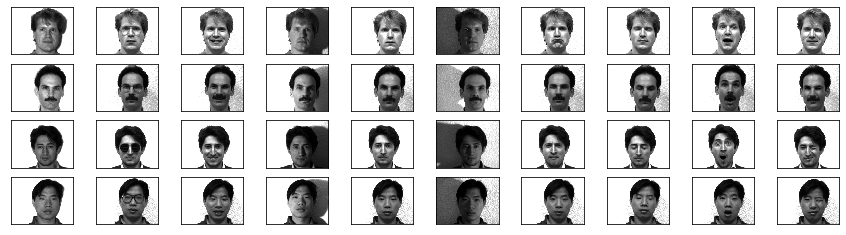

In [94]:
name = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15']
types = ['centerlight','glasses','happy','leftlight','noglasses','rightlight','sad','sleepy','surprised','wink']

#读取所有训练图片
def read_images():
    faces = []
    dataSetDir = 'face_database/yalefaces/yalefaces/subject'   #路径
    for i in range(15):  #有15个人
        for j in range(10):  #每个人有10张脸不同的脸
            img = imageio.imread(dataSetDir+name[i]+'.'+types[j])  #读取图片
            faces.append(img)
    labels = []
    for i in name:
        for j in range(10):
            labels.append(int(i))
    return faces,labels

#显示读取的人脸
def show_image(images,i):
    plt.figure(figsize=(15,4))
    for j in range(i*10):
        plt.subplot(i,10,j+1)
        plt.imshow(images[j],'gray') #灰度
        plt.xticks([]),plt.yticks([])

def change(images):
    img_data = []
    for img in images:
        data = img.flatten()  #转换为一维数组
        img_data.append(data)
    return img_data

images,labels=read_images()
show_image(images,4)  #显示部分人脸图片
img_data = change(images)

In [95]:
img_data = array(img_data)
label_data = array(labels)

#拆分训练集、测试集
x_train,x_test,y_train,y_test = train_test_split(img_data,label_data, test_size=0.2)
y_test

array([12,  3, 14,  6,  5, 11, 15, 12,  4,  2, 11,  3,  4,  4,  4, 13,  6,
       13, 15, 14,  7,  9, 10,  6,  2,  3, 15,  1,  4,  2])

### 二、降维数据

In [96]:
#先训练PCA模型
pca=PCA(n_components=50)
pca.fit(x_train)

# 返回测试集和训练集降维后的数据集
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print('降维后的训练集：',x_train_pca.shape)
print('降维后的测试集：',x_test_pca.shape)

character = pca.components_   #返回具有最大方差的成分
mean = pca.mean_    #平均特征值

print('平均特征值：',mean)

#图片太大显示出不清晰，所以未显示特征图片

降维后的训练集： (120, 50)
降维后的测试集： (30, 50)
平均特征值： [122.95833333 122.94166667 123.24166667 ...  68.          68.
  68.        ]


In [97]:
#返回所保留的n_componets个成分各自的方差百分比，即单个变量方差贡献率
pca.explained_variance_ratio_

array([0.32002662, 0.14767401, 0.08923762, 0.07294027, 0.04608377,
       0.04029539, 0.02497704, 0.02259425, 0.02012513, 0.01583721,
       0.01352503, 0.01107448, 0.00914874, 0.0083998 , 0.0081825 ,
       0.00762243, 0.00687138, 0.00628087, 0.00593394, 0.00580344,
       0.00506192, 0.00503164, 0.00484694, 0.0042449 , 0.00404803,
       0.00399139, 0.00347009, 0.00332769, 0.00321695, 0.00293959,
       0.00278386, 0.00259854, 0.00241824, 0.00228614, 0.00222464,
       0.00211979, 0.00206974, 0.00194524, 0.00188048, 0.00184425,
       0.00180396, 0.00175594, 0.00169755, 0.00164779, 0.00157103,
       0.00148343, 0.00147891, 0.00142862, 0.00130955, 0.00127036])

### 三、不同算法进行人脸识别
### （1）SVM算法

In [124]:
#svm分类器
svc = SVC()
svc.fit(x_train_pca,y_train)
y_pred = svc.predict(x_test_pca)

print('预测值：',y_pred)
print('实际值：',y_test)
print('准确率：',svc.score(x_test_pca,y_test))
print(metrics.confusion_matrix(y_test,y_pred))      #混淆矩阵
  

预测值： [12  3  8  8  5 11  3 12  4  1 11 10  4  4  4 13  6 13 15 14  8  9 10  6
  2  3 15  1  4  1]
实际值： [12  3 14  6  5 11 15 12  4  2 11  3  4  4  4 13  6 13 15 14  7  9 10  6
  2  3 15  1  4  2]
准确率： 0.7666666666666667
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 2]]


In [125]:
#svm分类器，调整参数
svc = SVC(C=0.001,gamma=0.001,kernel='linear')
svc.fit(x_train_pca,y_train)
y_pred = svc.predict(x_test_pca)

print('预测值：',y_pred)
print('实际值：',y_test)
print('准确率：',svc.score(x_test_pca,y_test))

预测值： [12  3  3  3  5 11  7 12  4  2 11  3  4  4  4 13  6 13 15 14  7  9 10  6
  2  3 15  1  4  2]
实际值： [12  3 14  6  5 11 15 12  4  2 11  3  4  4  4 13  6 13 15 14  7  9 10  6
  2  3 15  1  4  2]
准确率： 0.9


### （2）kNN算法

In [126]:
#kNN算法
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_pca,y_train)
y_pred = knn.predict(x_test_pca)

print('预测值：',y_pred)
print('实际值：',y_test)
print('准确率：',knn.score(x_test_pca,y_test))

#算法的默认参数已是最优

预测值： [12  3  7  3  5 11  1 12  4  2 11  3  4  4  4 13 14  7 15 14  9  9 10  6
  2  3 15  1  4  2]
实际值： [12  3 14  6  5 11 15 12  4  2 11  3  4  4  4 13  6 13 15 14  7  9 10  6
  2  3 15  1  4  2]
准确率： 0.8


### （3）opencv自带的EigenFace算法

In [127]:
#EigenFace
model = cv2.face.EigenFaceRecognizer_create()  #定义人脸识别模型
model.train(x_train,y_train)  #训练模型

#测试模型
res = model.predict(x_test[10])
print(res)
print(y_test[10])

#计算其准确率
ress = []
true = 0
for i in range(len(x_test)):
    res = model.predict(x_test[i])
    if y_test[i] == res[0]:
        true = true+1

print('测试集识别准确率：%.2f'% (true/len(y_test)))


(11, 8535.963856556238)
11
测试集识别准确率：0.83


### 测试图片

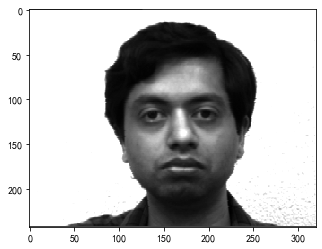

In [128]:
test_img = imageio.imread('face_database/yalefaces/yalefaces/subject10.normal')  #用未参与训练的normal类型的图片测试
plt.imshow(test_img,'gray')
plt.show()

In [129]:
res = model.predict(test_img)
print(res)

(10, 4920.306095274248)


## 使用haarcascades面部识别

引入了Cascade 分类器。它不是将6000个特征都用在一个窗口，而是将特征分为不同的阶段，然后一个阶段一个阶段的应用这些特征(通常情况下，前几个阶段只有很少量的特征)。如果窗口在第一个阶段就检测失败了，那么就直接舍弃它，无需考虑剩下的特征。如果检测通过，则考虑第二阶段的特征并继续处理。如果所有阶段的都通过了，那么这个窗口就是人脸区域。

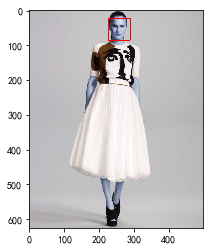

In [130]:
#haarcascades面部识别
#OpenCV 既可以作为检测器也可以进行训练。这些XML文件存储在opencv/data/haarcascades/文件夹中。
face_engine = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img = cv2.imread('face_database/att_face/test2.jpg')

faces = face_engine.detectMultiScale(img,scaleFactor=1.3,minNeighbors=5)

for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(img)
plt.show()